In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD,RMSprop
from keras.callbacks import *
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
import os,sys
import pickle
sys.path.append('/home/cs341seti/cs341-ibm-seti/')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from PIL import Image
import re
import collections
import sklearn
import commonutils as cu
import model_specs
from sklearn import svm
from sklearn.externals import joblib

## Try path tracing algorithm

In [3]:
fileListDF = pd.read_csv('../data/fileList.csv',dtype={'file_index':str})
fileListDF.head()
#fileListDF[fileListDF['signal_classification']=='squigglesquarepulsednarrowband'].head()

,file_name,signal_classification,uuid,file_index,label,dataset
0,00069203-0824-4136-9c99-b9f68672f23d.dat,squigglesquarepulsednarrowband,00069203-0824-4136-9c99-b9f68672f23d,000000,6,train
1,000739aa-89d6-4965-abf6-9b46a246604a.dat,narrowband,000739aa-89d6-4965-abf6-9b46a246604a,000001,2,train
2,000874dd-8d6e-44b1-8ade-21aeb5a29546.dat,narrowbanddrd,000874dd-8d6e-44b1-8ade-21aeb5a29546,000002,3,train
3,0009073c-4032-4b84-832a-9b81fc3b0df8.dat,brightpixel,0009073c-4032-4b84-832a-9b81fc3b0df8,000003,1,train
4,000c28b3-aeba-4f18-ac60-b91341921264.dat,squigglesquarepulsednarrowband,000c28b3-aeba-4f18-ac60-b91341921264,000004,6,train


In [191]:
def pathTrace(spectrogram,alpha,relativeSearchWindow=0.2):
    
    # Initializations
    spectrogram = np.squeeze(spectrogram)
    (nrow,ncol) = spectrogram.shape[0:2]
    nSearchWindowSize = int(ncol*relativeSearchWindow) # speed up by not looking very far current point
    lossMat = np.zeros((nrow,ncol))
    pathMat = np.zeros((nrow,ncol))
    trace_vector = np.zeros((nrow,))
    intensity_vector = np.zeros((nrow,))
    
    # to save compute-time create a delta matrix (d_ij = (f_i-f_j)^2)
    freqs = np.array(range(ncol))
    deltaMat = np.square(freqs[:,np.newaxis]-freqs)
    
    # For each time instant
    for t in range(nrow):
        # Initialize current row loss
        lossMat[t,:] = -alpha*spectrogram[t,:]
        # if first row, skip the search for best previous point
        if t==0: continue
        # for each frequency for rows 1 (second row) - end
        for f_current in range(ncol):
            # find best previous point
            #searchRange = range(max(f_current-nSearchWindowSize//2,0),min(f_current+nSearchWindowSize//2,ncol-1))
            loss_increments = lossMat[t-1,:] + (1-alpha)*deltaMat[f_current,:]
            f_best_prev = np.argmin(loss_increments)
            best_loss_increment = loss_increments[f_best_prev]
#             best_loss_increment = sys.float_info.max
#             f_best_prev = 0
#             searchRange = (max(f_current-nSearchWindowSize//2,0),min(f_current+nSearchWindowSize//2,ncol-1))
#             for f_prev in range(searchRange[0],searchRange[1]):
#                 loss_increment = lossMat[t-1,f_prev] + (1-alpha)*(f_prev-f_current)**2;
#                 if loss_increment < best_loss_increment:
#                     f_best_prev = f_prev
#                     best_loss_increment = loss_increment
            # update loss for f_current
            lossMat[t,f_current] += best_loss_increment
            # update locally chosen path for f_current
            pathMat[t,f_current] = f_best_prev
    
    # Finding the best last point and tracing back
    minLoss = np.min(lossMat[nrow-1,:])
    trace_vector[nrow-1] = np.argmin(lossMat[nrow-1,:])
    intensity_vector[nrow-1] = spectrogram[nrow-1,int(trace_vector[nrow-1])]
    # tracing back from end-1 to 0
    for t in range(nrow-2,-1,-1):
        trace_vector[t] = pathMat[t+1,int(trace_vector[t+1])]
        intensity_vector[t] = spectrogram[t,int(trace_vector[t])]
    
    return [trace_vector,intensity_vector,minLoss]  

def generatePathTrace(alpha,dataset,file_index,base_path):
    x = img_to_array(load_img('{}{}.jpg'.format(base_path,file_index),grayscale=True))
    [trace,intensity,minLoss] = pathTrace(cu.modelutils.columnNormalize(x),alpha)
    return np.dstack([trace,intensity])

In [209]:
basepath = '../data/welch_specdataimages_gray_256x512_6/'
fid = '000010'
x = img_to_array(load_img('{}{}.jpg'.format(basepath,fid),grayscale=True))

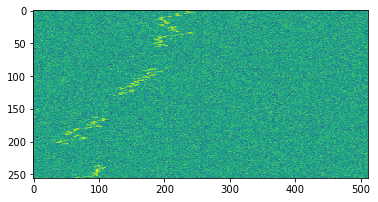

In [210]:
plt.imshow((x[:,:,0]))
plt.show()

In [216]:
%time [trace,intensity,minLoss] = pathTrace(cu.modelutils.columnNormalize(x),0.5)
print(minLoss)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s
-5474.25


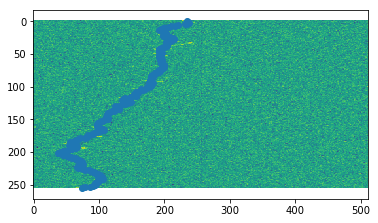

In [122]:
plt.imshow(x[:,:,0])
plt.scatter(trace,range(256))
plt.show()

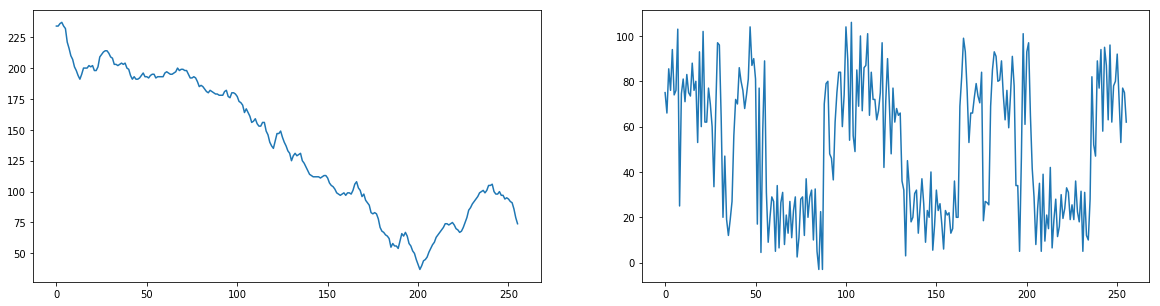

In [123]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(trace)
plt.subplot(122)
plt.plot(intensity)
plt.show()

In [167]:
np.dstack([trace,intensity]).shape

(1, 256, 2)

# Generate traces for all images

In [ ]:
%%time
alpha = 0.5
imsize = (256,512)
loader = cu.traceutils.pathTraceLoader(alpha,(256,2))
basepath = '../data/welch_specdataimages_gray_256x512_6/'
# n x t x 2 array containing 2 time-series: trace, intensity for all signals
n = len(fileListDF)
traceDataset = np.zeros((n,imsize[0],2))
for i in range(n):
    print '\r{}'.format(i),
    traceDataset[i] = loader.loaderFn('{}{}.jpg'.format(basepath,fileListDF['file_index'].ix[i]))
np.save('../data/alltraces_0.5alpha.npy',traceDataset)

# Generate dataset with traces

In [4]:
alpha = 0.2
sourcePath = '../data/welch_specdataimages_gray_256x512_6/'
fileListPath = '../data/fileList.csv'
destfname = '../data/traceDataset_0.2alpha.hdf5'
loader = cu.traceutils.pathTraceLoader(alpha,(256,2))
cu.datautils.createDataset(sourcePath=sourcePath,fileListPath=fileListPath,destFilename=destfname,
                           loadImages=False,loaderFn=loader.loaderFn,datShape=loader.shape)

Picking files of extension jpg
The number of files is 15985


train set: 8175 / 12085                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

train set: 12085 / 12085                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# Experimenting with some traces 

In [ ]:
%%time
alpha = 0.2
imsize = (256,512)
loader = cu.traceutils.pathTraceLoader(alpha,(256,2))
basepath = '../data/welch_specdataimages_gray_256x512_6/'
# n x t x 2 array containing 2 time-series: trace, intensity for all signals
n = 1000
traceDataset = np.zeros((n,imsize[0],2))
for i in range(n):
    print '\r{}'.format(i),
    traceDataset[i] = loader.loaderFn('{}{}.jpg'.format(basepath,fileListDF['file_index'].ix[i]))

In [10]:
traceDataset.shape

(1000, 256, 2)

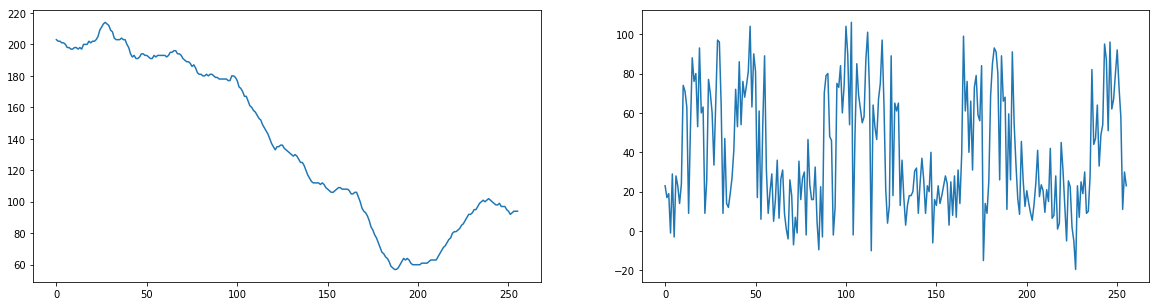

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(traceDataset[10,:,0])
plt.subplot(122)
plt.plot(traceDataset[10,:,1])
plt.show()